# Explore your results from *Imputer* on Open Humans.  

If you'd like to learn how to explore you're imputed genotypes, please follow along in the cells below.  
Plese see [openimpute.com/about](http://openimpute.com/about) or the [GitHub page](https://github.com/arvkevi/openhumansimputer) for questions.

In [1]:
import os
import io
import bz2

import pandas as pd

import requests
from ohapi import api

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user = api.exchange_oauth2_member(os.environ.get('OH_ACCESS_TOKEN'))

Imputation results were returned in [vcf](https://samtools.github.io/hts-specs/VCFv4.3.pdf) format, the next cell will download your imputed genotype file.

In [3]:
for record in user['data']:
    if record['basename'] == 'member.imputed.vcf.bz2':
        print('Found your imputed genotype data in Open Humans!')
        datafile = requests.get(record['download_url']).content
        datafile = bz2.decompress(datafile)
        break

Found your imputed genotype data in Open Humans!


## Select a Chromosome to analyze  
Not all chromosomes will fit into memory on the server, so in this example, choose one.  
The next three cells will subset your `vcf` file to a single chromosome and will convert the data into a [pandas](https://pandas.pydata.org/) `DataFrame`.

In [4]:
# {1-22, 'X'}
chrom = '5'

In [5]:
vcf_array = []
for line in datafile.splitlines():

    # this will stop searching the file if the chromsome has been read.
    if len(vcf_array) > 0 and not line.startswith(chrom.encode('utf-8')):
        print('Finished loading chromosome {}, stopping early'.format(chrom))
        break
    
    # add the genetic variants from the user-defined chrom
    if line.startswith(chrom.encode('utf-8')):
        vcf_array.append(line.decode('utf-8'))
del datafile

Finished loading chromosome 5, stopping early


In [6]:
df = pd.read_csv(io.StringIO('\n'.join(vcf_array)),
            sep='\t',
            comment='#',
            header=None,
            names=[
                'CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'
            ])
df.set_index(['CHROM', 'POS', 'REF', 'ALT'], inplace=True)

There are 4 columns which serve as a unique index for genomic position:  
`CHROM`, `POS`, `REF`, and `ALT`  

To clean up the `DataFrame`, drop some columns that aren't used:  
`ID` is a unique string, essentially a concatenated form of the unique index.  
`QUAL` is `.` for every position, we did not store this data type.  
`FILTER` is also `.` for every position, we did not store this data type.  

In [7]:
df.head()

ID QUAL FILTER           INFO FORMAT  \
CHROM POS   REF ALT                                                  
5     10056 A   C    5_10056_A_C    .      .  PR;INFO=0.001  GT:GP   
      10062 A   C    5_10062_A_C    .      .    PR;INFO=0.0  GT:GP   
      10063 A   C    5_10063_A_C    .      .  PR;INFO=0.052  GT:GP   
      10067 T   A    5_10067_T_A    .      .    PR;INFO=0.0  GT:GP   
      10099 A   C    5_10099_A_C    .      .   PR;INFO=0.97  GT:GP   

                                  SAMPLE  
CHROM POS   REF ALT                       
5     10056 A   C    0/0:0.998,0.002,0.0  
      10062 A   C        0/0:1.0,0.0,0.0  
      10063 A   C    0/0:0.885,0.115,0.0  
      10067 T   A        0/0:1.0,0.0,0.0  
      10099 A   C    0/1:0.015,0.985,0.0

In [8]:
df.drop(['ID', 'QUAL', 'FILTER'], axis=1, inplace=True)

In [9]:
df.head()

INFO FORMAT               SAMPLE
CHROM POS   REF ALT                                           
5     10056 A   C    PR;INFO=0.001  GT:GP  0/0:0.998,0.002,0.0
      10062 A   C      PR;INFO=0.0  GT:GP      0/0:1.0,0.0,0.0
      10063 A   C    PR;INFO=0.052  GT:GP  0/0:0.885,0.115,0.0
      10067 T   A      PR;INFO=0.0  GT:GP      0/0:1.0,0.0,0.0
      10099 A   C     PR;INFO=0.97  GT:GP  0/1:0.015,0.985,0.0

The next cell will transform the remaining columns into a more usable format.  

Specifically:  
`INFO` will be parsed and float value after `INFO=` will be extracted.  
`FORMAT` will be dropped, it is used to inform the reader what is contained in the `SAMPLE` field.  
`SAMPLE` will be split and parsed into two columns as indicated by `FORMAT` -- `GT` and `GP`.  
`GT` is your genotype at that genomic position.  
`GP` is the probability output by the *Imputer* pipeline that the `GT` is correct.

In [10]:
info = df['INFO'].str.split(';', expand=True)
df['INFO'] = info[1].str.split('=', expand=True)[1].astype(float)
del info

df.drop(['FORMAT'], axis=1, inplace=True)

sample = df['SAMPLE'].str.split(':', expand=True)
df['GT'] = sample[0]
df['GP'] = sample[1]
df.drop(['SAMPLE'], inplace=True, axis=1)
del sample

In [11]:
df.head()

INFO   GT               GP
CHROM POS   REF ALT                             
5     10056 A   C    0.001  0/0  0.998,0.002,0.0
      10062 A   C    0.000  0/0      1.0,0.0,0.0
      10063 A   C    0.052  0/0  0.885,0.115,0.0
      10067 T   A    0.000  0/0      1.0,0.0,0.0
      10099 A   C    0.970  0/1  0.015,0.985,0.0

## post-impuation QC  
The INFO metric serves as a "confidence" that the genotype is called accurately. From the [IMPUTE2 homepage](http://mathgen.stats.ox.ac.uk/impute/impute_v2.html):  

>Our metric typically takes values between 0 and 1, where values near 1 indicate that a SNP has been imputed with high certainty. The metric can occasionally take negative values when the imputation is very uncertain, and we automatically assign a value of -1 when the metric is undefined (e.g., because it wasn't calculated).

>Investigators often use the info metric to remove poorly imputed SNPs from their association testing results. There is no universal cutoff value for post-imputation SNP filtering; various groups have used cutoffs of 0.3 and 0.5, for example, but the right threshold for your analysis may differ. One way to assess different info thresholds is to see whether they produce sensible Q-Q plots, although we emphasize that Q-Q plots can look bad for many reasons besides your post-imputation filtering scheme.

Let's take an inclusive approach and set a cutoff of **0.3**  
How many sites were considered to be imputed with high confidence?

All snps: 867428
High confidence snps: 163374
% hi conf snps: 18.83%


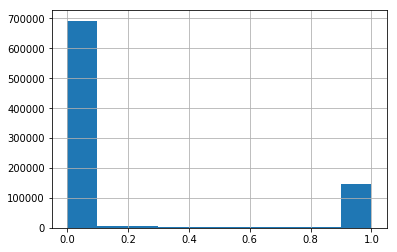

In [12]:
n_snps = df.shape[0]
n_hiconf_snps = df.loc[df['INFO']>=0.3].shape[0]
print('All snps: {}'.format(n_snps))
print('High confidence snps: {}'.format(n_hiconf_snps))
print('% hi conf snps: {0:.2f}%'.format((n_hiconf_snps / n_snps)*100))

df['INFO'].hist();

Take a look at the possible values for the `GT` field:  
`0/0` indicates you are homozygous reference at this position.  
`0/1` indicates you are heterozygous at this position.  
`1/1` indicates you are homozygous alternate at this position.  
`./.` indicates that the *GP* threshold of `0.6` was not met at this position, so no call was made.  
*The `./.` threshold was arbitrarily chosen.*

In [13]:
df['GT'].value_counts()

0/0    567302
0/1    155154
1/1    138541
./.      6431
Name: GT, dtype: int64

The next cell will split the genotype probabilities into three columns:  
1. `GP_homref` for homozygous reference calls
2. `GP_het` for heterozygous calls
3. `GP_homalt` for homozygous alterante calls

In [14]:
gp = df['GP'].str.split(',', expand=True)
df['GP_homref'] = gp[0].astype(float)
df['GP_het'] = gp[1].astype(float)
df['GP_homalt'] = gp[2].astype(float)
del gp
df.drop(['GP'], axis=1, inplace=True)

In [15]:
df.head()

INFO   GT  GP_homref  GP_het  GP_homalt
CHROM POS   REF ALT                                          
5     10056 A   C    0.001  0/0      0.998   0.002        0.0
      10062 A   C    0.000  0/0      1.000   0.000        0.0
      10063 A   C    0.052  0/0      0.885   0.115        0.0
      10067 T   A    0.000  0/0      1.000   0.000        0.0
      10099 A   C    0.970  0/1      0.015   0.985        0.0

Take a closer look at the genotype probabilities, `GP`, for the uncalled sites, they are very uncertain, with a maximum genotype probability of much lower than `1.0`.

In [17]:
df.loc[df['GT'] == './.'][['GP_homref', 'GP_het', 'GP_homalt']].astype(float).max(axis=1).head()

CHROM  POS     REF  ALT
5      16120   A    T      0.555
       83380   A    C      0.555
       92468   G    GTA    0.555
       262306  C    G      0.555
       272367  C    T      0.555
dtype: float64

Hopefully this notebook will help you explore your imputed genotype data, if you have any questions or suggestions please open an issue on the [GitHub page](https://github.com/arvkevi/openhumansimputer).